In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np


In [2]:
# Carrega o dataset completo com preços, geração, load, e clima
df = pd.read_csv("dataset.csv", parse_dates=['time'])
df.set_index('time', inplace=True)

# Verifica se a coluna de preço está presente
print(df.columns[df.columns.str.contains("price", case=False)])

Index(['price day ahead', 'price actual'], dtype='object')


In [3]:
def add_lag_and_time_features(df):
    df = df.copy()
    df['lag_1h'] = df['price actual'].shift(1)
    df['lag_24h'] = df['price actual'].shift(24)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df.dropna()

df_prepared = add_lag_and_time_features(df)


In [4]:
def create_fixed_yearly_splits(df):
    """
    Cria 3 janelas fixas com treino e teste de 1 ano cada.
    """
    df = df.copy()
    df = df.sort_index()

    splits = []

    ranges = [
        ('2015-01-01', '2015-12-31', '2016-01-01', '2016-12-31'),
        ('2016-01-01', '2016-12-31', '2017-01-01', '2017-12-31'),
        ('2017-01-01', '2017-12-31', '2018-01-01', '2018-12-31')
    ]

    for train_start, train_end, test_start, test_end in ranges:
        df_train = df.loc[train_start:train_end]
        df_test = df.loc[test_start:test_end]
        splits.append((df_train, df_test))

    return splits

splits = create_fixed_yearly_splits(df_prepared)

# Visualizar os períodos
for i, (train, test) in enumerate(splits, start=1):
    print(f"Janela {i}:")
    print(f"  Treino: {train.index.min().date()} → {train.index.max().date()}  ({len(train)} registos)")
    print(f"  Teste:  {test.index.min().date()} → {test.index.max().date()}  ({len(test)} registos)\n")


Janela 1:
  Treino: 2015-01-01 → 2015-12-31  (8737 registos)
  Teste:  2016-01-01 → 2016-12-31  (8784 registos)

Janela 2:
  Treino: 2016-01-01 → 2016-12-31  (8784 registos)
  Teste:  2017-01-01 → 2017-12-31  (8760 registos)

Janela 3:
  Treino: 2017-01-01 → 2017-12-31  (8760 registos)
  Teste:  2018-01-01 → 2018-12-31  (8759 registos)



In [5]:
forecast_horizon = 24  # ou 168 para longo prazo
df_prepared['target'] = df_prepared['price actual'].shift(-forecast_horizon)
df_prepared = df_prepared.dropna(subset=['target'])

In [6]:
def evaluate_model_across_splits(splits, model_type='lr', forecast_horizon=24):
    """
    Avalia um modelo em 3 janelas com várias métricas.
    """
    results = []

    for i, (df_train, df_test) in enumerate(splits, start=1):
        # Prepara features e target
        df_train = df_train.copy()
        df_test = df_test.copy()

        df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
        df_test['target'] = df_test['price actual'].shift(-forecast_horizon)

        df_train.dropna(subset=['target'], inplace=True)
        df_test.dropna(subset=['target'], inplace=True)

        drop_cols = ['price actual', 'price day ahead', 'target']
        feature_cols = [col for col in df_train.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['target'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['target'].values

        # Escolher o scaler adequado
        if model_type == 'lstm':
            scaler_X = MinMaxScaler()
            scaler_y = MinMaxScaler()
        else:
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

        # Escolher o modelo
        if model_type == 'lr':
            model = LinearRegression()
        elif model_type == 'rf':
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        elif model_type == 'xgb':
            model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
        else:
            raise ValueError("Modelo não suportado.")

        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        # Métricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'janela': i,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

    return results


In [7]:
# Avaliar modelos com short-term horizon (24h)
lr_short = evaluate_model_across_splits(splits, model_type='lr', forecast_horizon=24)
rf_short = evaluate_model_across_splits(splits, model_type='rf', forecast_horizon=24)
xgb_short = evaluate_model_across_splits(splits, model_type='xgb', forecast_horizon=24)

# Converter para DataFrames e visualizar
import pandas as pd
df_lr_short = pd.DataFrame(lr_short)
df_rf_short = pd.DataFrame(rf_short)
df_xgb_short = pd.DataFrame(xgb_short)

display(df_lr_short)
display(df_rf_short)
display(df_xgb_short)


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,7.957580,10.011144,22.501569,0.167673
1,2,5.432815,7.269426,9.934683,0.091588
2,3,5.850958,7.586063,11.058253,0.092054


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,10.471912,13.029550,30.478953,0.220652
1,2,5.329747,7.577350,9.257782,0.089850
2,3,5.204729,7.048966,10.388009,0.081887


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,10.233174,12.760701,29.841585,0.215622
1,2,5.385594,7.638750,9.321094,0.090791
2,3,5.348389,7.300667,10.742070,0.084147


In [8]:
def evaluate_lstm_on_splits(splits, forecast_horizon=24, timesteps=24, units=50, batch_size=32, epochs=10):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from sklearn.preprocessing import MinMaxScaler
    import numpy as np
    results = []

    for i, (df_train, df_test) in enumerate(splits, start=1):
        df_train = df_train.copy()
        df_test = df_test.copy()
        df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
        df_test['target'] = df_test['price actual'].shift(-forecast_horizon)
        df_train.dropna(subset=['target'], inplace=True)
        df_test.dropna(subset=['target'], inplace=True)

        drop_cols = ['price actual', 'price day ahead', 'target']
        feature_cols = [col for col in df_train.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['target'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['target'].values

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

        def build_sequences(X, y, timesteps):
            Xs, ys = [], []
            for i in range(timesteps, len(X)):
                Xs.append(X[i - timesteps:i])
                ys.append(y[i])
            return np.array(Xs), np.array(ys)

        X_train_seq, y_train_seq = build_sequences(X_train_scaled, y_train_scaled, timesteps)
        X_test_seq, y_test_seq = build_sequences(X_test_scaled, y_test_scaled, timesteps)

        model = Sequential()
        model.add(LSTM(units, activation='relu', input_shape=(timesteps, X_train_seq.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, verbose=0)

        y_pred_scaled = model.predict(X_test_seq).ravel()
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_test_real = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

        from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
        mae = mean_absolute_error(y_test_real, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
        mape = mean_absolute_percentage_error(y_test_real, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test_real))

        results.append({
            'janela': i,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

    return results


In [9]:
lstm_short = evaluate_lstm_on_splits(splits, forecast_horizon=24)
df_lstm_short = pd.DataFrame(lstm_short)
display(df_lstm_short)


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


,janela,MAE,RMSE,MAPE (%),rMAE
0,1,11.952109,14.532040,32.556180,0.251765
1,2,6.262427,9.266538,10.893157,0.105618
2,3,8.054555,9.974735,14.764093,0.126636


In [10]:
def tune_random_forest_short(splits, forecast_horizon=24):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    import pandas as pd

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20]
    }

    results = []

    for n in param_grid['n_estimators']:
        for d in param_grid['max_depth']:
            maes, rmses, mapes, rmaes = [], [], [], []

            for df_train, df_test in splits:
                df_train = df_train.copy()
                df_test = df_test.copy()
                df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
                df_test['target'] = df_test['price actual'].shift(-forecast_horizon)
                df_train.dropna(subset=['target'], inplace=True)
                df_test.dropna(subset=['target'], inplace=True)

                drop_cols = ['price actual', 'price day ahead', 'target']
                feature_cols = [col for col in df_train.columns if col not in drop_cols]

                X_train = df_train[feature_cols].values
                y_train = df_train['target'].values
                X_test = df_test[feature_cols].values
                y_test = df_test['target'].values

                scaler_X = StandardScaler()
                scaler_y = StandardScaler()
                X_train_scaled = scaler_X.fit_transform(X_train)
                X_test_scaled = scaler_X.transform(X_test)
                y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
                y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

                model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=42)
                model.fit(X_train_scaled, y_train_scaled)
                y_pred_scaled = model.predict(X_test_scaled)
                y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mape = mean_absolute_percentage_error(y_test, y_pred) * 100
                rmae = mae / np.mean(np.abs(y_test))

                maes.append(mae)
                rmses.append(rmse)
                mapes.append(mape)
                rmaes.append(rmae)

            results.append({
                'n_estimators': n,
                'max_depth': d,
                'MAE': np.mean(maes),
                'RMSE': np.mean(rmses),
                'MAPE (%)': np.mean(mapes),
                'rMAE': np.mean(rmaes)
            })

    return pd.DataFrame(results)


In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

def tune_xgboost_short_extended(splits, forecast_horizon=24):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1]
    }

    results = []

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                maes, rmses, mapes, rmaes = [], [], [], []

                for train_df, test_df in splits:
                    # Garantir que há uma coluna target (24h à frente)
                    train = train_df.copy()
                    test = test_df.copy()

                    train['target'] = train['price actual'].shift(-forecast_horizon)
                    test['target'] = test['price actual'].shift(-forecast_horizon)

                    train = train.dropna()
                    test = test.dropna()

                    X_train, y_train = train.drop(columns=['target']), train['target']
                    X_test, y_test = test.drop(columns=['target']), test['target']

                    model = XGBRegressor(n_estimators=n_estimators,
                                         max_depth=max_depth,
                                         learning_rate=learning_rate,
                                         random_state=42,
                                         n_jobs=-1)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                    mae = mean_absolute_error(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
                    rmae = mae / np.mean(np.abs(y_test))

                    maes.append(mae)
                    rmses.append(rmse)
                    mapes.append(mape)
                    rmaes.append(rmae)

                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'MAE': np.mean(maes),
                    'RMSE': np.mean(rmses),
                    'MAPE (%)': np.mean(mapes),
                    'rMAE': np.mean(rmaes)
                })

    return pd.DataFrame(results)

xgb_tuning_short_ext = tune_xgboost_short_extended(splits, forecast_horizon=24)
display(xgb_tuning_short_ext.sort_values(by='MAPE (%)'))


,n_estimators,max_depth,learning_rate,MAE,RMSE,MAPE (%),rMAE
2,100,6,0.10,6.378271,8.638286,15.310112,0.118017
10,200,6,0.05,6.384061,8.641389,15.342194,0.118237
11,200,6,0.10,6.442335,8.703298,15.357543,0.119042
20,300,6,0.10,6.493953,8.745261,15.434854,0.119968
19,300,6,0.05,6.464791,8.709346,15.499743,0.119771
1,100,6,0.05,6.422032,8.713261,15.595370,0.119275
4,100,8,0.05,6.654114,8.964124,15.901408,0.123523
18,300,6,0.01,6.513313,8.886572,15.931449,0.121016
13,200,8,0.05,6.695946,8.981319,15.950158,0.124293
22,300,8,0.05,6.743692,9.029553,16.059352,0.125226


In [12]:
def tune_lstm(splits, forecast_horizon=168, timesteps=24, epochs=10):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from sklearn.preprocessing import MinMaxScaler
    import numpy as np

    param_grid = {
        'units': [50, 100],
        'batch_size': [16, 32]
    }

    results = []

    for units in param_grid['units']:
        for batch_size in param_grid['batch_size']:
            maes, mapes, rmses, rmaes = [], [], [], []

            for df_train, df_test in splits:
                df_train = df_train.copy()
                df_test = df_test.copy()

                df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
                df_test['target'] = df_test['price actual'].shift(-forecast_horizon)

                df_train.dropna(subset=['target'], inplace=True)
                df_test.dropna(subset=['target'], inplace=True)

                drop_cols = ['price actual', 'price day ahead', 'target']
                feature_cols = [col for col in df_train.columns if col not in drop_cols]

                X_train = df_train[feature_cols].values
                y_train = df_train['target'].values
                X_test = df_test[feature_cols].values
                y_test = df_test['target'].values

                scaler_X = MinMaxScaler()
                scaler_y = MinMaxScaler()
                X_train_scaled = scaler_X.fit_transform(X_train)
                X_test_scaled = scaler_X.transform(X_test)
                y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
                y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

                # Sequências
                def build_sequences(X, y, timesteps):
                    Xs, ys = [], []
                    for i in range(timesteps, len(X)):
                        Xs.append(X[i - timesteps:i])
                        ys.append(y[i])
                    return np.array(Xs), np.array(ys)

                X_train_seq, y_train_seq = build_sequences(X_train_scaled, y_train_scaled, timesteps)
                X_test_seq, y_test_seq = build_sequences(X_test_scaled, y_test_scaled, timesteps)

                model = Sequential()
                model.add(LSTM(units, activation='relu', input_shape=(timesteps, X_train_seq.shape[2])))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')
                model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, verbose=0)

                y_pred_scaled = model.predict(X_test_seq).ravel()
                y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
                y_test_real = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

                mae = mean_absolute_error(y_test_real, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
                mape = mean_absolute_percentage_error(y_test_real, y_pred) * 100
                rmae = mae / np.mean(np.abs(y_test_real))

                maes.append(mae)
                rmses.append(rmse)
                mapes.append(mape)
                rmaes.append(rmae)

            results.append({
                'units': units,
                'batch_size': batch_size,
                'MAE': np.mean(maes),
                'RMSE': np.mean(rmses),
                'MAPE (%)': np.mean(mapes),
                'rMAE': np.mean(rmaes)
            })

    return pd.DataFrame(results)

lstm_tuning_results = tune_lstm(splits)
display(lstm_tuning_results)


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,units,batch_size,MAE,RMSE,MAPE (%),rMAE
0,50,16,10.167979,12.673406,23.830560,0.189062
1,50,32,11.745568,14.342070,27.256671,0.219810
2,100,16,11.181703,13.765991,25.639413,0.206929
3,100,32,9.994653,12.674313,23.695956,0.185781


In [ ]:
rf_tuning_short = tune_random_forest_short(splits, forecast_horizon=24)
display(rf_tuning_short)

lstm_tuning_short = tune_lstm(splits, forecast_horizon=24)
display(lstm_tuning_short)

,n_estimators,max_depth,MAE,RMSE,MAPE (%),rMAE
0,100,10,7.019253,9.256496,16.839805,0.131325
1,100,20,6.986324,9.208311,16.665619,0.130450
2,200,10,6.989734,9.226858,16.774761,0.130761
3,200,20,6.969730,9.188223,16.640560,0.130185


,n_estimators,learning_rate,max_depth,MAE,RMSE,MAPE (%),rMAE
0,100,0.05,6,6.944378,9.201390,16.712527,0.129554
1,100,0.05,8,6.987618,9.222759,16.617511,0.130088
2,100,0.10,6,6.989052,9.233372,16.634916,0.130187
3,100,0.10,8,7.114110,9.326786,16.810336,0.132563
4,200,0.05,6,6.884400,9.114542,16.425533,0.128140
5,200,0.05,8,6.976331,9.192232,16.521931,0.129813
6,200,0.10,6,7.086756,9.304382,16.751861,0.131963
7,200,0.10,8,7.123263,9.328684,16.781062,0.132642


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,units,batch_size,MAE,RMSE,MAPE (%),rMAE
0,50,16,8.750731,10.974152,20.123017,0.163022
1,50,32,8.681696,10.793931,19.101175,0.160896
2,100,16,8.703054,10.584854,18.361318,0.159632
3,100,32,9.302238,11.393654,20.416664,0.171522


In [22]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import t
import numpy as np

# Função Diebold–Mariano
def diebold_mariano(e1, e2, h=1):
    d = e1 - e2
    d_mean = np.mean(d)
    d_var = np.var(d, ddof=1)
    dm_stat = d_mean / np.sqrt(d_var / len(d))
    p_value = 2 * (1 - t.cdf(np.abs(dm_stat), df=len(d) - 1))
    return dm_stat, p_value

# Recriar Janela 3 (caso já não exista)
df_train, df_test = splits[2]
forecast_horizon = 24
df_train = df_train.copy()
df_test = df_test.copy()
df_train['target'] = df_train['price actual'].shift(-forecast_horizon)
df_test['target'] = df_test['price actual'].shift(-forecast_horizon)
df_train.dropna(subset=['target'], inplace=True)
df_test.dropna(subset=['target'], inplace=True)

# Features e targets
drop_cols = ['price actual', 'price day ahead', 'target']
feature_cols = [col for col in df_train.columns if col not in drop_cols]
X_train = df_train[feature_cols]
y_train = df_train['target']
X_test = df_test[feature_cols]
y_test = df_test['target'].values

# Previsão XGBoost
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Previsão LSTM (com scalers)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# Criar sequências para LSTM
def build_sequences(X, y, timesteps=24):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i - timesteps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = build_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = build_sequences(X_test_scaled, y_test_scaled)

# Treinar LSTM simples
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(24, X_train_seq.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

# Previsão e inversão da escala
y_pred_lstm_scaled = model_lstm.predict(X_test_seq).ravel()
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).ravel()
y_true_aligned = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

# Aplicar Diebold-Mariano
e_xgb = np.abs(y_true_aligned - y_pred_xgb[-len(y_true_aligned):])
e_lstm = np.abs(y_true_aligned - y_pred_lstm)

dm_stat, p_val = diebold_mariano(e_xgb, e_lstm)

print(f"📊 Diebold-Mariano Statistic: {dm_stat:.4f}")
print(f"📌 p-value: {p_val:.4f}")


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
📊 Diebold-Mariano Statistic: -52.0542
📌 p-value: 0.0000


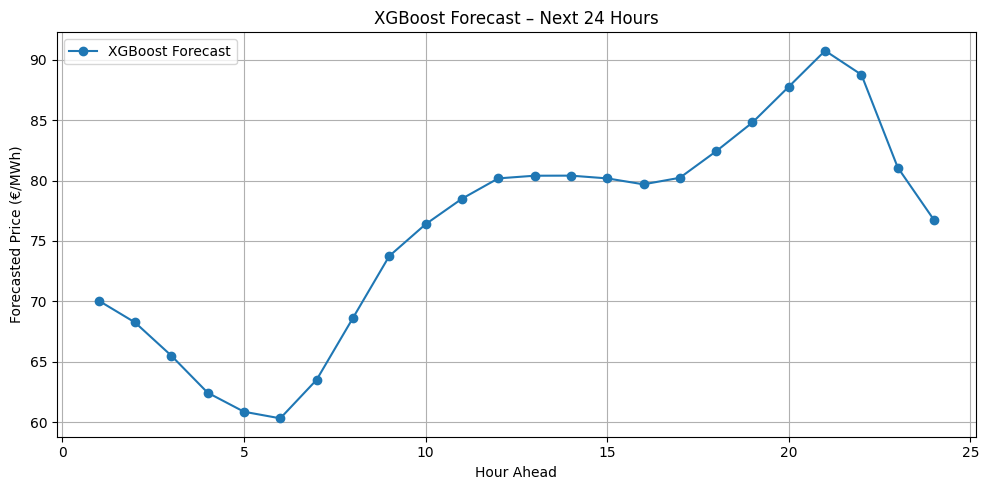

In [23]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 1. Preparar os dados mais recentes
feature_cols = [col for col in df_prepared.columns if col not in ['price actual', 'price day ahead', 'target']]
latest_input = df_prepared[feature_cols].iloc[-24:].copy()

# 2. Treinar scaler e modelo com todo o histórico disponível
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = df_prepared[feature_cols]
y = df_prepared['price actual']

scaler_X.fit(X)
scaler_y.fit(y.values.reshape(-1, 1))

X_scaled = scaler_X.transform(X)
y_scaled = scaler_y.transform(y.values.reshape(-1, 1)).ravel()

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_scaled, y_scaled)

# 3. Fazer previsão recursiva para as próximas 24 horas
xgb_forecast_scaled = []

for step in range(24):
    input_scaled = scaler_X.transform(latest_input[feature_cols])
    pred_scaled = xgb_model.predict(input_scaled[-1:])  # usar a última hora como base
    xgb_forecast_scaled.append(pred_scaled[0])

    # Inverter para adicionar no input seguinte
    pred_inv = scaler_y.inverse_transform([[pred_scaled[0]]])[0][0]

    next_row = latest_input.iloc[-1:].copy()
    next_row['lag_1h'] = pred_inv
    next_row['lag_24h'] = latest_input.iloc[-24]['lag_1h']

    next_row['hour'] = (next_row['hour'] + 1) % 24
    next_row['hour_sin'] = np.sin(2 * np.pi * next_row['hour'] / 24)
    next_row['hour_cos'] = np.cos(2 * np.pi * next_row['hour'] / 24)
    next_row['day_of_week'] = (next_row['day_of_week'] + (next_row['hour'] == 0).astype(int)) % 7
    next_row['dow_sin'] = np.sin(2 * np.pi * next_row['day_of_week'] / 7)
    next_row['dow_cos'] = np.cos(2 * np.pi * next_row['day_of_week'] / 7)

    latest_input = pd.concat([latest_input.iloc[1:], next_row])

# 4. Inverter escala para obter valores finais
xgb_forecast = scaler_y.inverse_transform(np.array(xgb_forecast_scaled).reshape(-1, 1)).flatten()

# 5. Plot do resultado
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25), xgb_forecast, marker='o', label='XGBoost Forecast')
plt.title("XGBoost Forecast – Next 24 Hours")
plt.xlabel("Hour Ahead")
plt.ylabel("Forecasted Price (€/MWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
